<a href="https://colab.research.google.com/github/chwonghk01/typo-detection/blob/master/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

project_id = 'data-poc-227904'
!gcloud config set project {project_id}

import os
import tensorflow as tf
import json
import pprint
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print(TPU_WORKER)
with tf.Session(TPU_WORKER) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.
  
print(tf.VERSION)
print(tf.keras.__version__)

!gsutil -m rsync -r -x "dataset/.*" gs://hk01dev-typo-detection/repo .

Updated property [core/project].
grpc://10.88.171.154:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 13973520210494597777),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16192842029227720757),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 14618793684832556948),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6335597719759094063),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6204147311189132552),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5303342256533438054),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11847006913015718264),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8435381503593628705),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU

In [0]:
!gsutil -m rsync -r -x "dataset/.*" gs://hk01dev-typo-detection/repo .
# Count number of records

import tensorflow as tf
with tf.gfile.Open('./config/colab_config.json', "r") as reader:
  CONFIG = json.loads(reader.read())
  
def count_records(files):
  c = 0
  for fn in files:
    for record in tf.python_io.tf_record_iterator(fn):
      c+=1
  return c
    
train_count = count_records(tf.gfile.Glob(CONFIG["train_config"]["train_files"]))
eval_count = count_records(tf.gfile.Glob(CONFIG["eval_config"]["eval_files"]))
predict_count = count_records(tf.gfile.Glob(CONFIG["predict_config"]["predict_files"]))

train_steps = train_count // CONFIG["batch_size"]
eval_steps = eval_count // CONFIG["batch_size"]
predict_steps = predict_count // CONFIG["batch_size"]

train_steps, eval_steps, predict_steps

Building synchronization state...
Starting synchronization...
Copying gs://hk01dev-typo-detection/repo/config/colab_config.json...
/ [1/1 files][  1.6 KiB/  1.6 KiB] 100% Done                                    
Operation completed over 1 objects/1.6 KiB.                                      


(136816, 1433, 748)

In [0]:
!gsutil -m rsync -r -x "dataset/.*" gs://hk01dev-typo-detection/repo .
 
num_epoch = 1 #@param{"type": "integer"}

for i in range(num_epoch):
  print(("*" * 10) + " EPOCH %d "%i + ("*"*10))
  !python -m trainer.task \
    --tpu_name={TPU_WORKER} \
    --config_file=./config/colab_config.json \
    --do_export=true \
    --do_train=true \
    --do_eval=true \
    --del_ckpt=true

Building synchronization state...
Starting synchronization...
********** EPOCH 0 **********
INFO:tensorflow:Using config: {'_model_dir': 'gs://hk01dev-typo-detection/ckpt_v5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      value: "10.88.171.154:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f91a37cee80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': b'grpc://10.88.171.154:8470', '_evaluation_master': b'grpc://10.88.171.154:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replic

Building synchronization state...
Starting synchronization...


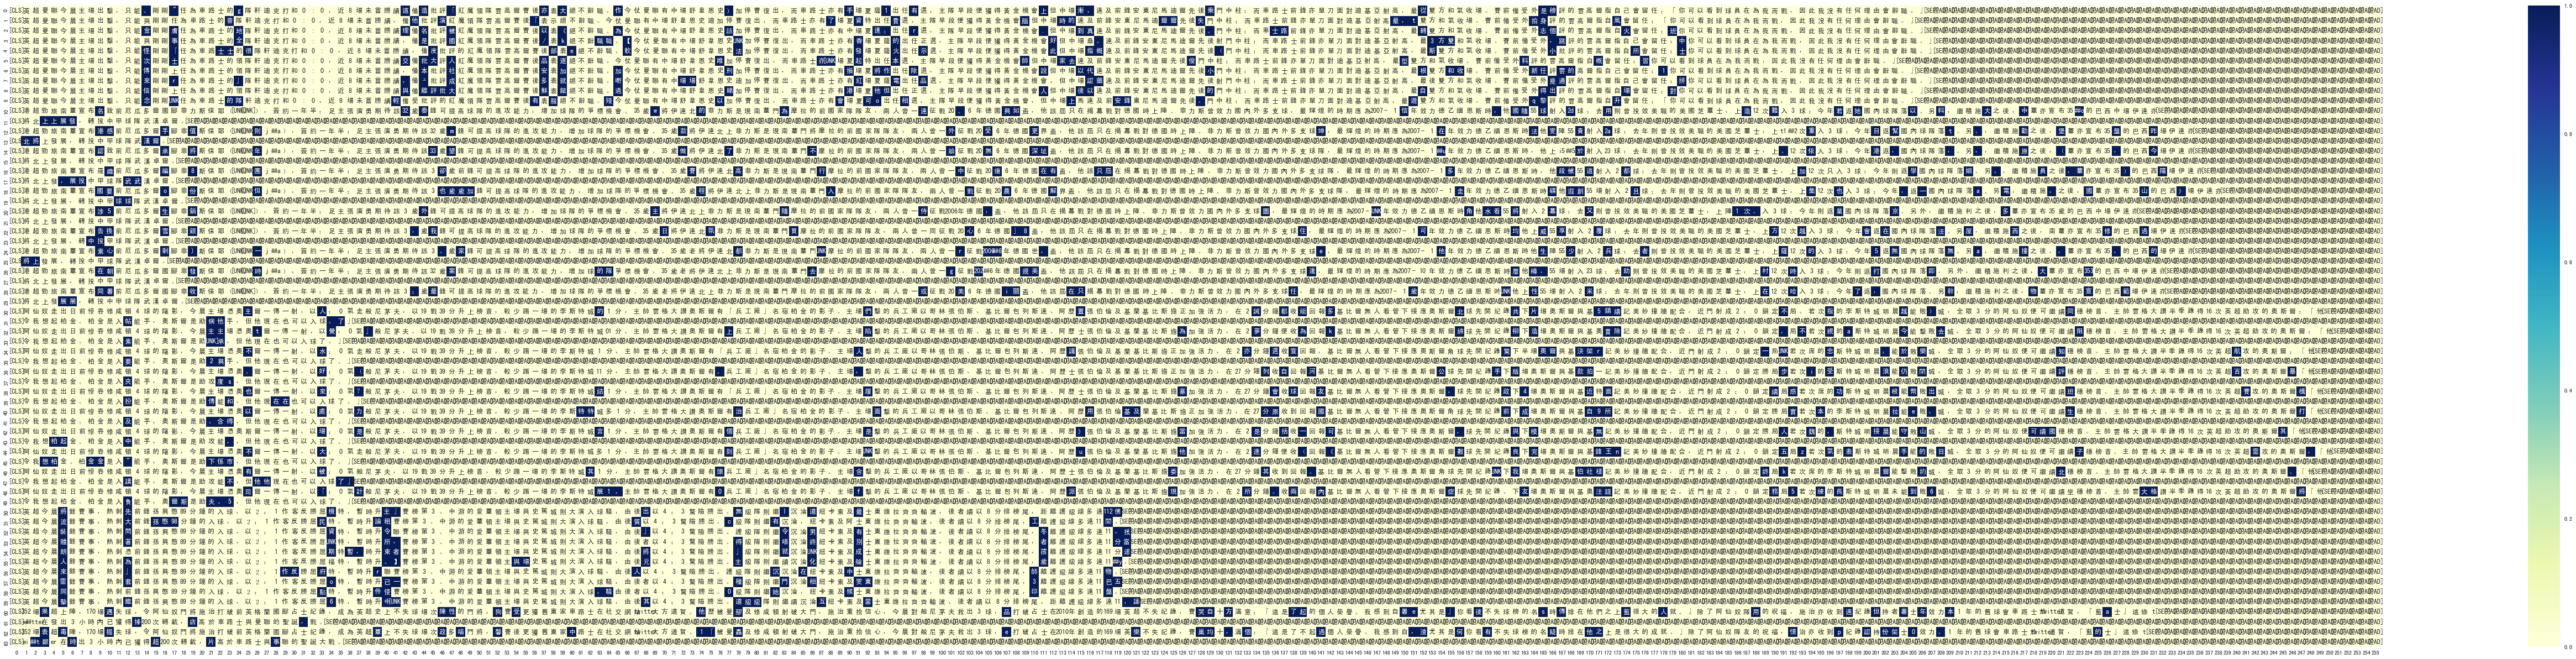

In [0]:
# Visualize tfrecords

!gsutil -m rsync -r gs://hk01dev-typo-detection/repo .

ASSETS_DIR = './assets' #@param{'type': 'string'}
INPUT_DATA = './dataset/v5/train_256_part_0.tfrecords' #@param{'type': 'string'}
MAX_SEQ_LENGTH = 256 #@param{'type': 'integer'}
BATCH_SIZE = 64 #@param{'type': 'integer'}


pred = None
  
import tensorflow as tf
import os
from trainer.transform import create_tokenizer
import numpy as np
from utils import visualize


import sys
sys.path.append('./assets/')


from trainer.input import input_fn_builder
tf.logging.set_verbosity(tf.logging.INFO)


input_fn = input_fn_builder(
    file_names=[INPUT_DATA],
    seq_length=MAX_SEQ_LENGTH,
    shuffle=False,
    repeat=False,
    drop_remainder=True
)


with tf.Session() as sess:
    tensor = input_fn(params={'batch_size': BATCH_SIZE}).make_one_shot_iterator().get_next()
    inp = sess.run(tensor)

    
input_ids = inp['input_ids']
truth = inp['truths']
tokenizer = create_tokenizer('assets/chinese_L-12_H-768_A-12/vocab.txt')
text = np.array([tokenizer.convert_ids_to_tokens(input_id) for input_id in input_ids])
visualize(ASSETS_DIR, text, truth, display_rows=BATCH_SIZE)

Building synchronization state...
Starting synchronization...
Copying gs://hk01dev-typo-detection/repo/request.json...
Copying gs://hk01dev-typo-detection/repo/model.py...
Copying gs://hk01dev-typo-detection/repo/api.py...
Copying gs://hk01dev-typo-detection/repo/response.json...
/ [4/4 files][337.3 KiB/337.3 KiB] 100% Done                                    
Operation completed over 4 objects/337.3 KiB.                                    


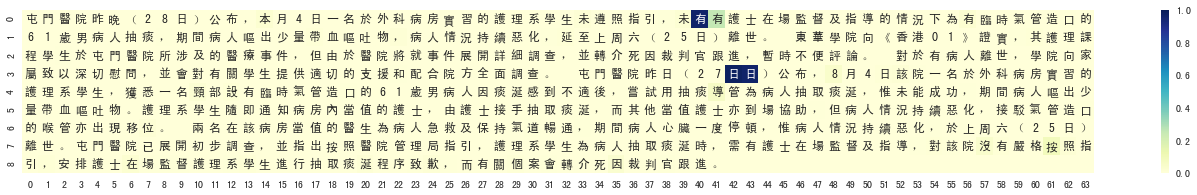

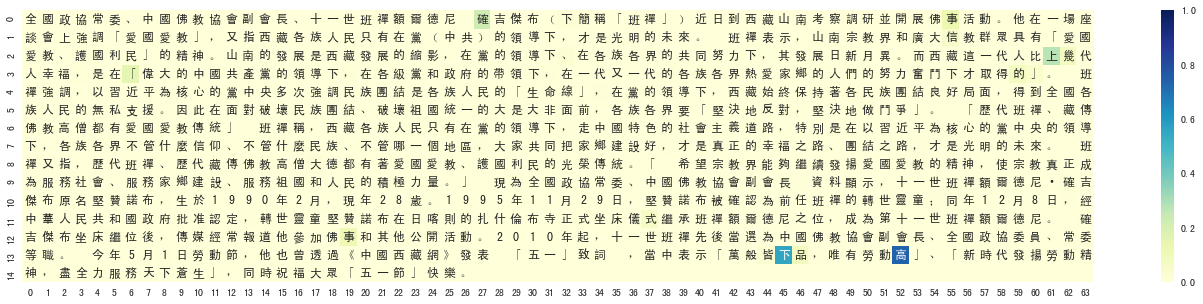

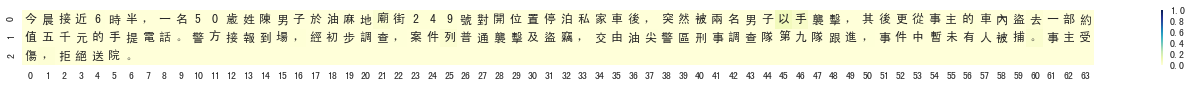

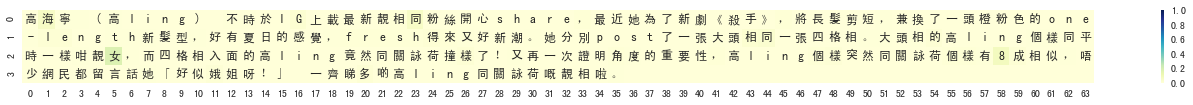

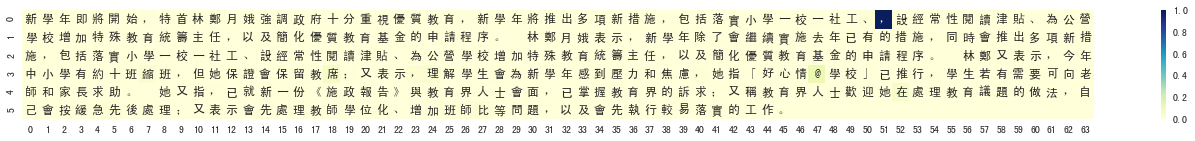

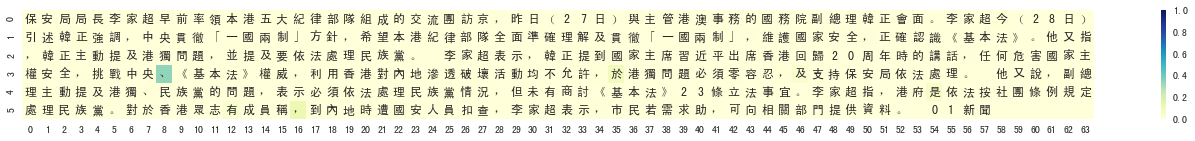

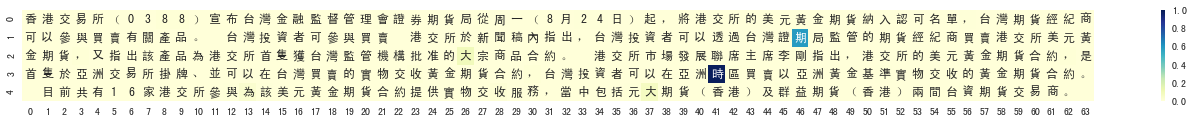

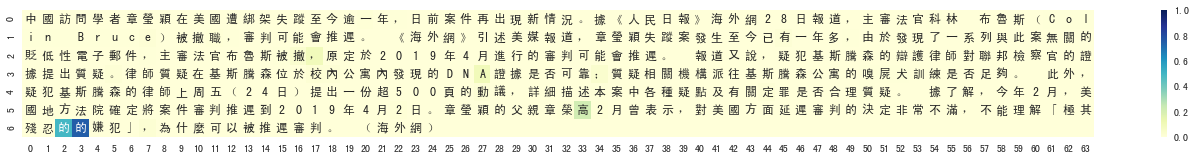

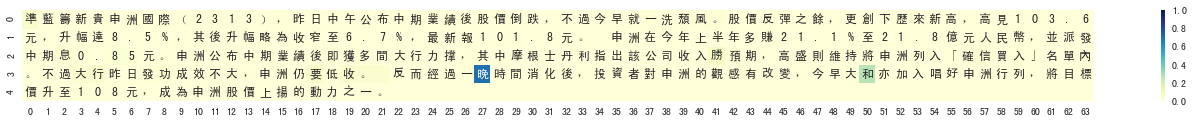

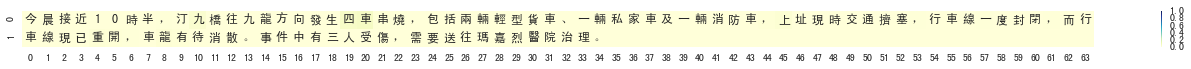

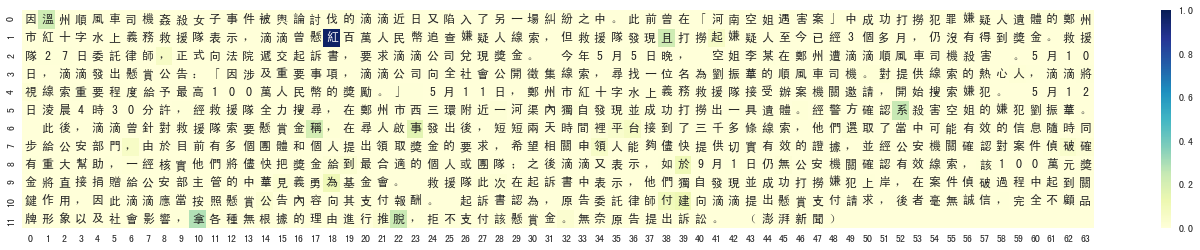

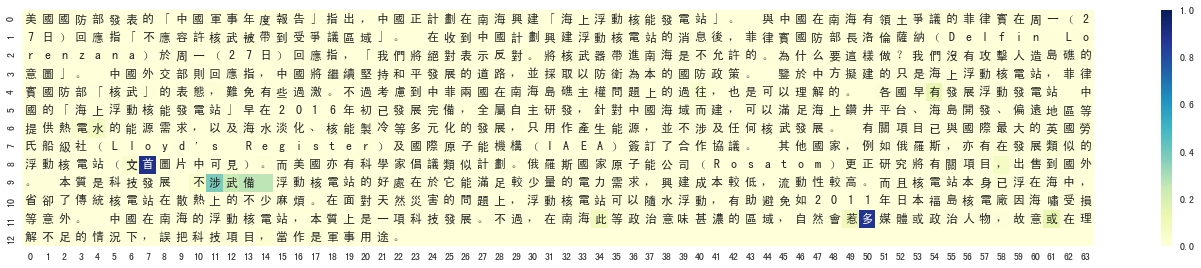

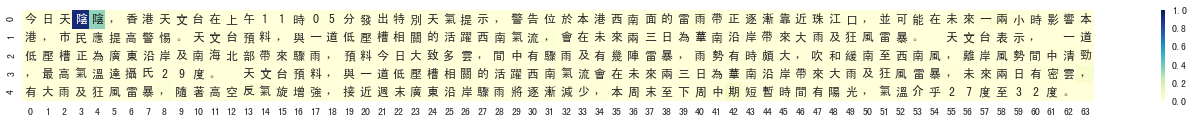

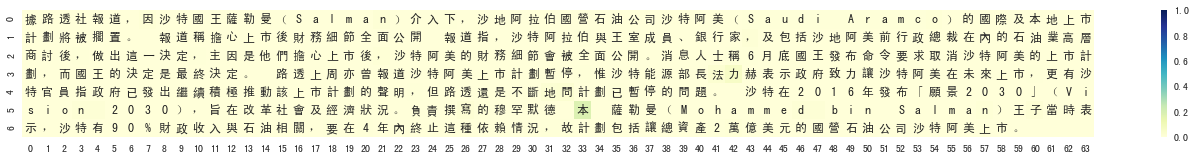

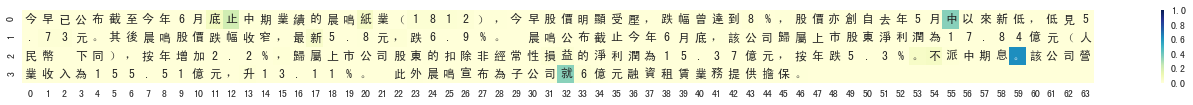

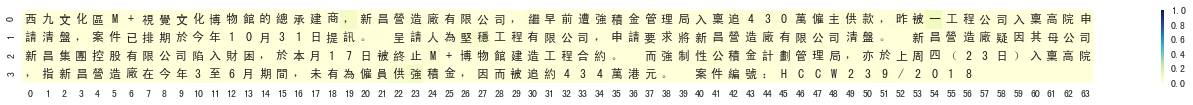

In [0]:
!gsutil -m rsync -r gs://hk01dev-typo-detection/repo .

ASSETS_DIR = './assets' #@param{'type': 'string'}
  
from matplotlib import font_manager
import seaborn as sns
import json
from utils import visualize_article
with open('./response.json', 'r') as f:
  data = [json.loads(item) for item in filter(None,f.read().split('\n'))]

# font_files = font_manager.findSystemFonts(fontpaths=ASSETS_DIR)
# font_list = font_manager.createFontList(font_files)
# font_manager.fontManager.ttflist.extend(font_list)
# sns.set_style("darkgrid",{"font.sans-serif":['SimHei', 'Arial']})
# sns.set()

for i in range(len(data)):
  visualize_article(ASSETS_DIR, data[i]['text'], data[i]['predictions'])

In [0]:
from matplotlib import font_manager
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

ASSETS_DIR = './assets'
font_files = font_manager.findSystemFonts(fontpaths=ASSETS_DIR)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
sns.set_style("darkgrid",{"font.sans-serif":['SimHei', 'Arial']})
print(font_list)

text = np.array([['三', '一', '一']])
pred = np.array([[1.0, 0.2, 0.3]])
fig, ax = plt.subplots(figsize=(24 * text.shape[1] // 64, text.shape[0] / 3))
sns.heatmap(pred, annot=text, fmt='', cmap="YlGnBu", ax=ax, vmin=0, vmax=1)

[<Font 'SimHei' (SimHei.ttf) normal normal 400 normal>, <Font 'SimHei' (chinese.simhei.ttf) normal normal 400 normal>]


In [0]:
!head response.json

{"text": "\u5c6f\u9580\u91ab\u9662\u6628\u665a\uff0828\u65e5\uff09\u516c\u5e03\uff0c\u672c\u67084\u65e5\u4e00\u540d\u65bc\u5916\u79d1\u75c5\u623f\u5be6\u7fd2\u7684\u8b77\u7406\u7cfb\u5b78\u751f\u672a\u9075\u7167\u6307\u5f15\uff0c\u672a\u6709\u6709\u8b77\u58eb\u5728\u5834\u76e3\u7763\u53ca\u6307\u5c0e\u7684\u60c5\u6cc1\u4e0b\u70ba\u6709\u81e8\u6642\u6c23\u7ba1\u9020\u53e3\u768461\u6b72\u7537\u75c5\u4eba\u62bd\u75f0\uff0c\u671f\u9593\u75c5\u4eba\u5614\u51fa\u5c11\u91cf\u5e36\u8840\u5614\u5410\u7269\uff0c\u75c5\u4eba\u60c5\u6cc1\u6301\u7e8c\u60e1\u5316\uff0c\u5ef6\u81f3\u4e0a\u5468\u516d\uff0825\u65e5\uff09\u96e2\u4e16\u3002 \u6771\u83ef\u5b78\u9662\u5411\u300a\u9999\u6e2f01\u300b\u8b49\u5be6\uff0c\u5176\u8b77\u7406\u8ab2\u7a0b\u5b78\u751f\u65bc\u5c6f\u9580\u91ab\u9662\u6240\u6d89\u53ca\u7684\u91ab\u7642\u4e8b\u4ef6\uff0c\u4f46\u7531\u65bc\u91ab\u9662\u5c07\u5c31\u4e8b\u4ef6\u5c55\u958b\u8a73\u7d30\u8abf\u67e5\uff0c\u4e26\u8f49\u4ecb\u6b7b\u56e0\u88c1\u5224\u5b98\u8ddf\u9032\uff0c\u66ab\u

Building synchronization state...
Starting synchronization...


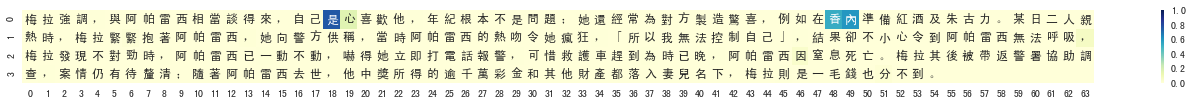

In [0]:
!gsutil -m rsync -r gs://hk01dev-typo-detection/repo .

from utils import visualize_typo
# visualize_typo('./assets', "愉景灣昨晚有巴士乘客與司機發生爭執，兩名操國語女乘客，疑因搬運行李時碰撞與男司機爭執，一人拉扯男司機頭髮，一人從旁指罵，司機發出痛苦的叫聲，但無還擊之力，任由大媽欺凌。案件原列作糾紛，惟於事發片段流出後，警方發現案件有明顯刑事成分，並改列普通襲擊調查。一段網上片段拍得於愉景灣一巴士站內，一輛巴士於埋站後，兩名操國語女乘客疑與巴士男司機發生爭執，其中一名女乘客先拉扯男司機衣領搖晃，其後用手拉扯其頭髮，要求男司機「抬頭！讓大家看看」，又著同伴拍攝車長，車長狀甚痛苦，「哎」一聲呼叫，大叫欲甩開對方，另一名拖著女童的女乘客則在旁指罵司機，歷時近10秒後一名男子在旁嘗試調停，兩女方停手。公司：對暴力行為零容忍　已報警有網民指，當時大媽指責司機煞車，令她的小孩跌倒。但懷疑當時小童並沒坐好，車上的成年人也未有好好看管小孩，煞車時除了小孩外，沒其他人跌倒。經營愉景灣巴士的香港興業表示，已確認旗下巴士車長於昨晚遭襲擊，公司對暴力行為零容忍，已報警要求警方介入及跟進。原列糾紛　片段流出改列襲擊警方昨晚7時許接報，於愉景北商場巴士站一名36歲姓李內地女子報案，指於搬運行李時因碰撞問題與46歲巴士男司機發生爭執，事件中無人受傷，相信不涉及刑事，列作糾紛處理。據了解，警方昨晚於接報後到場，發現該名施襲內地女已離開，而男司機稱不打算追究，因此案件原列糾紛。惟於事發片段流出後，警方發現案件有明顯刑事成分，因此警方將重新調查案件，並改列普通襲擊。警方大嶼北分區正跟進案件，現正追緝一名年齡介乎40至50歲女子，蓄短直黑髮，戴眼鏡，案發時身穿黑色長袖外套、藍色長牛仔褲及深色鞋。")
visualize_typo('./assets', "梅拉強調，與阿帕雷西相當談得來，自己是心喜歡他，年紀根本不是問題；她還經常為對方製造驚喜，例如在香內準備紅酒及朱古力。某日二人親熱時，梅拉緊緊抱著阿帕雷西，她向警方供稱，當時阿帕雷西的熱吻令她瘋狂，「所以我無法控制自己」，結果卻不小心令到阿帕雷西無法呼吸，梅拉發現不對勁時，阿帕雷西已一動不動，嚇得她立即打電話報警，可惜救護車趕到為時已晚，阿帕雷西因窒息死亡。梅拉其後被帶返警署協助調查，案情仍有待釐清；隨著阿帕雷西去世，他中獎所得的逾千萬彩金和其他財產都落入妻兒名下，梅拉則是一毛錢也分不到。")